_Purpose_ of this notebook is Exploratary Data Analysis.

_Contents_ of this notebooks is as follows:

_Summary_ of key findings and decisions are as follows:
* There are three distinct classes in the brief that are human names, namely (puns unintended),artist, athelete, and office holder. Without explicit profession sometiumes supplied in parathensis within 'name' or additional contexts of external datasets, one's name should not contain information that reasonably and fairly implies one's profession. Therefore, when a profession is not included in the 'name' field, the designed model should only output a class called 'human names' rather than attempted prediction of profession based on whatever spurious associations or biases there may be in training data;
* The distribution includinng the few noted specificities in the supplied dataset will be _assumed_ to mirror distribution of the dataset that the ML application will be deployed on, i.e. what's expected of customers' input. The noted specificities include (1) presence of non-ascii words is highly uneven across classes; (2) names for classes plant and animal are mainly their scientific Latin names. If this assumption is violated, then collection of more diverse data points  should be pursued to ensure generalizability of the model.

In [1]:
import pandas as pd
import seaborn as sns
import string
import warnings
import matplotlib.pyplot as plt

from textblob import TextBlob

warnings.filterwarnings("ignore")

### 1. read in data

In [6]:
df = pd.read_csv('/home/jupyter/sb-entity-classification/data/data.csv')
classes_list = pd.read_csv('/home/jupyter/sb-entity-classification/data/classes.txt', header = None)

In [7]:
classes_list['class'] = classes_list.index
classes_list.columns = ['class_name', 'class']
df.columns = ['class','name']
classes_list['class'] = classes_list['class'] + 1  # based on information provided in the brief

In [8]:
classes_list.head(3)

,class_name,class
0,Company,1
1,EducationalInstitution,2
2,Artist,3


In [9]:
df.head(2)

,class,name
0,1,E. D. Abbott Ltd
1,1,Schwan-Stabilo


### 2. initial check of data quality

In [10]:
print('df has {} rows and {} cols'.format(df.shape[0], df.shape[1]))
df = df.drop_duplicates()
print('after dedup, df has {} rows and {} cols'.format(df.shape[0], df.shape[1]))

df has 548787 rows and 2 cols
after dedup, df has 548787 rows and 2 cols


In [11]:
df.isnull().sum()

class    0
name     0
dtype: int64

No null values or duplicates in data

In [12]:
if len(df['name'].unique()) == df.shape[0]:
    print('All good :) Every row has a distinct name in df')
else:
    print('Alert: The same name has been labeled as different classes.')

All good :) Every row has a distinct name in df


### 3. Initial examination of examples per class

<AxesSubplot:xlabel='class'>

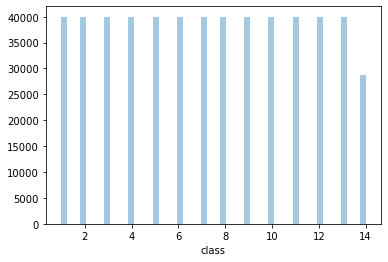

In [15]:
sns.distplot(df['class'], kde = False)

Same number of examples (40k) per class, except for the last class (30k examples)

In [16]:
classes_list

,class_name,class
0,Company,1
1,EducationalInstitution,2
2,Artist,3
3,Athlete,4
4,OfficeHolder,5
5,MeanOfTransportation,6
6,Building,7
7,NaturalPlace,8
8,Village,9
9,Animal,10


In [17]:
groups = df.groupby('class')

for i in classes_list['class'].unique():
    print('Examples of names for class {} are:'.format(classes_list[classes_list['class'] ==i]['class_name'].values[0]))
    example_names = groups.get_group(i).sample(5)['name'].values
    print(example_names, '\n')

Examples of names for class Company are:
['Source Technologies' 'MAKO Surgical Corp.' 'KTM' 'Microscan Systems'
 'Amer Sports'] 

Examples of names for class EducationalInstitution are:
["Académie internationale Mohammed VI de l'aviation civile"
 'Universidad Argentina de la Empresa'
 'Manipal College of Dental Sciences Mangalore' 'Vanderbilt University'
 'Jawaharlal Nehru Medical College Aligarh'] 

Examples of names for class Artist are:
['Steven Pippin' 'Mary Ingham' 'Shalom Hanoch' 'Keith Ferguson (musician)'
 'Emilie Poulsson'] 

Examples of names for class Athlete are:
["Una O'Dwyer (camogie)" 'Marc-Vivien Foé' 'Kyle Russell'
 'Fernando Marcelo Campagnolo' 'Steve Billirakis'] 

Examples of names for class OfficeHolder are:
['Hijikata Katsunaga' 'Saidi Bwanamdogo' 'Joseph Preston Jr.'
 'Said Mohammad Sammour' 'Yu Zhengsheng'] 

Examples of names for class MeanOfTransportation are:
['Maserati 6CM' 'USS Glover (FF-1098)' 'Martin-Baker MB 3'
 'USS Southerland (DD-743)' 'USS Taconic (

_Observations_:
1. class name and class number are matched (as verified by the printed examples)
2. texts in name include:
(1) non-English words and non-ascii characters, such as 'Messaggero Veneto – Giornale del Friuli' and 'Otłoczynek'. 
(2) brackets and punctuation, such as 'Anna Lucasta (1959 film)' and 'I Want to Live!'. 
(3) some key words such as 'album', 'film', 'musician' are included in brackets, which could be especially useful for classification of genre. 
(4) length of texts in 'names' varies.  

### 4. Quantify the observed qualities of texts 

In [18]:
df_features = df.copy()
df_features = df_features.merge(classes_list, on = 'class')

#### 4.1 Length of texts in names and whether the distribution varies across classes.

In [19]:
df_features['num_chars'] = df['name'].str.len()

<AxesSubplot:xlabel='num_chars'>

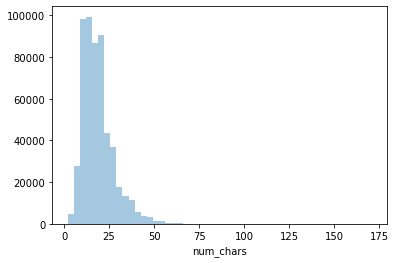

In [20]:
sns.distplot(df_features['num_chars'], kde = False)

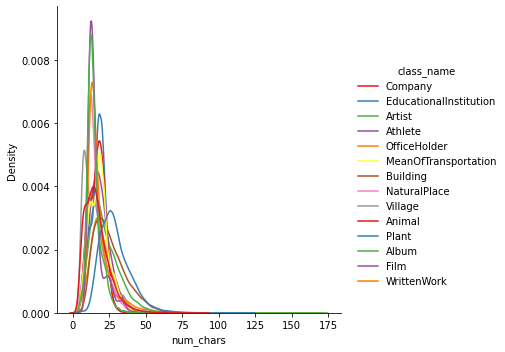

In [21]:
sns.displot(data=df_features, x='num_chars', hue='class_name', kind='kde', palette='Set1')

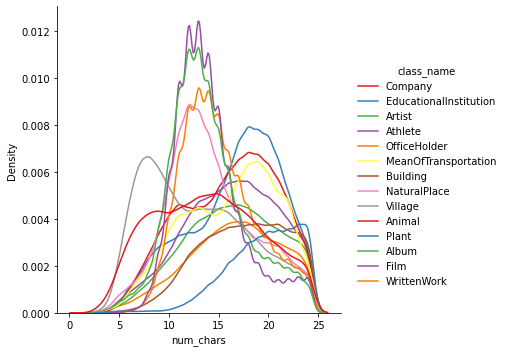

In [22]:
### Zoom in to the more dense area (without the long tail)
sns.displot(data = df_features[df_features['num_chars']<25], x='num_chars', hue='class_name', kind='kde', palette='Set1')

_Observations_:
1. Class 'Plant' seems more likely to have longer names (due to the fact that many of / potentially all of them are Latin names);
2. 'Athlete' and 'Artist', two classes that refer to human names, seem to have a similar distritbution of length, peaking more prominantly around 12 characters. Interestingly, OfficeHolder, another class that refers to human names, is slightly less concentrated at the medium length. 

This observed similarity of char count distribution between these human names classes further prompt the question: how would the model be able to identify someone's profession from the name, unless it's explicitly stated, as it is the case in the example of 'Keith Ferguson (musician)'?

#### 4.2 Number of words in names and whether the distribution varies across classes.

In [25]:
df_features['num_words'] = df_features['name'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='num_words'>

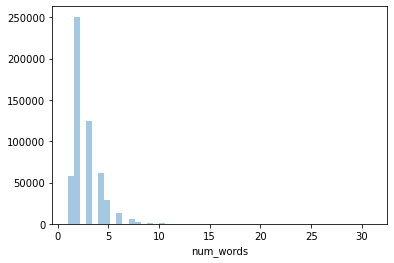

In [96]:
sns.distplot(df_features['num_words'], kde = False)

In [97]:
df_features['num_words'].max() # useful to know when tokenising words during preprocessing

31

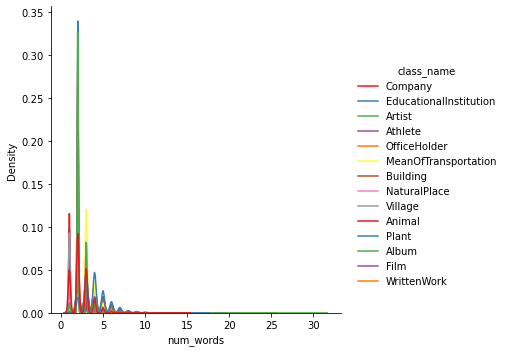

In [27]:
sns.displot(data=df_features, x='num_words', hue='class_name', kind='kde', palette='Set1')

<BarContainer object of 14 artists>

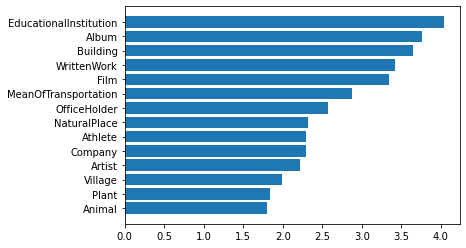

In [28]:
plt.barh(df_features.groupby('class_name').mean()['num_words'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_words'].sort_values(), 
         align='center')

In [50]:
print(df_features[df_features['class_name'] == 'Animal'].sample(3)['name'].values)
print(df_features[df_features['class_name'] == 'Plant'].sample(3)['name'].values)

['Red triangle slug' 'Vanitrochus geertsi' 'Paractinoceras']
['Ocimum centraliafricanum' 'Vitis tsoii' 'Vigna owahuensis']


Plant (and some Animals classes) in this dataset contain latin names, explaining the few, long words contained in their names. This should be noted - if the ML application expects customers to input colliqual plant or animal names, then labeled data with more similar names for these two classes would need to be collected, and this model to retrain. 

#### 4.3 Number of punctuations, digits, nonascii characters in names and whether the distribution varies across classes.

In [29]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])  

In [30]:
df_features['num_punctuations']= df_features['name'].apply(lambda x: count(x,set(string.punctuation)))
df_features['num_ascii']= df_features['name'].apply(lambda x: count(x,set(string.ascii_letters)))
df_features['num_whitespace']= df_features['name'].apply(lambda x: count(x,set(string.whitespace)))
df_features['num_digits']= df_features['name'].apply(lambda x: count(x,set(string.digits)))

df_features['num_nonascii'] = df_features['num_chars']-df_features['num_punctuations']-df_features['num_digits']-df_features['num_ascii']- df_features['num_whitespace']

df_features = df_features.drop(['num_whitespace', 'num_ascii'], axis = 1)

In [31]:
df_features.head(2)

,class,name,class_name,num_chars,num_word,num_words,num_punctuations,num_digits,num_nonascii
0,1,E. D. Abbott Ltd,Company,16,4,4,2,0,0
1,1,Schwan-Stabilo,Company,14,1,1,1,0,0


<BarContainer object of 14 artists>

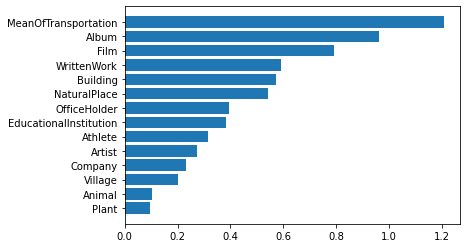

In [32]:
plt.barh(df_features.groupby('class_name').mean()['num_punctuations'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_punctuations'].sort_values(), 
         align='center')

<BarContainer object of 14 artists>

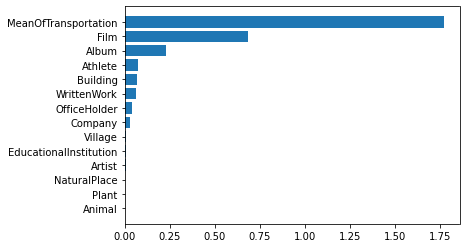

In [33]:
plt.barh(df_features.groupby('class_name').mean()['num_digits'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_digits'].sort_values(), 
         align='center')

In [44]:
df_features[df_features['class_name'] == 'MeanOfTransportation'][df_features['num_digits']>1].sample(5)

,class,name,class_name,num_chars,num_word,num_words,num_punctuations,num_digits,num_nonascii
224087,6,HMS Providence (J325),MeanOfTransportation,21,3,3,2,3,0
235389,6,USS Enterprise (1874),MeanOfTransportation,21,3,3,2,4,0
203413,6,HMAS Jervis Bay (AKR 45),MeanOfTransportation,24,5,5,2,2,0
233099,6,USS Lacerta (AKA-29),MeanOfTransportation,20,3,3,3,2,0
234097,6,USS Cabell (AK-166),MeanOfTransportation,19,3,3,3,3,0


Numbers that exist in MeanOfTransportation seem to be mainly either part of a historical year, or make of the model.

<BarContainer object of 14 artists>

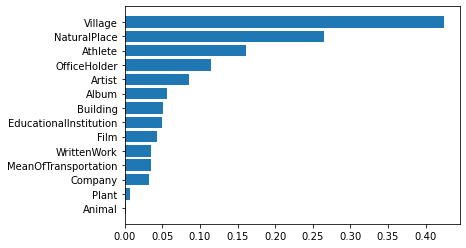

In [45]:
plt.barh(df_features.groupby('class_name').mean()['num_nonascii'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_nonascii'].sort_values(), 
         align='center')

In [93]:
print('Overall, {:.2%} of all records contain nonascii characters'.format(len(df_features[df_features['num_nonascii'] > 0])/ len(df_features)))
print('For class Village, {:.2%} of all records contain nonascii characters'.format(len(df_features[df_features['num_nonascii'] > 0].query("class_name == 'Village'"))/ len(df_features.query("class_name == 'Village'"))))
print('For class NaturalPlace, {:.2%} of all records contain nonascii characters'.format(len(df_features[df_features['num_nonascii'] > 0].query("class_name == 'NaturalPlace'"))/ len(df_features.query("class_name == 'NaturalPlace'"))))

Overall, 7.06% of all records contain nonascii characters
For class Village, 26.70% of all records contain nonascii characters
For class NaturalPlace, 18.98% of all records contain nonascii characters


The significantly higher presence of non-ascii characters in village, and overall uneven distribution of that among most classes, is potentially an issue. A machine learning algorithm trained on the current dataset is very likely to overfit on the spurious association of presence of 'exotic' characters in village or natural place names, even though generally, there is nothing inherently more exotic about these entities compared to the others. However, if the particular use case of this ML application expects a consistently similar distribution to what's present in this dataset for some reason, then there may be a case this confounder (presence of non-ascii characters) can be exploited mindfully, under close review of ongoing data drift, though a reframing of the class names may be more fitting and future-proof.

#### 4.4 Detected language in names and whether the distribution varies across classes.

In [240]:
def safe_detect_language(text):
    if len(text) >3:
        return TextBlob(text).detect_language()
    else:
        return None

Since TextBlob apparentlyy uses MyMemory API under the hood, which has a 1000 requests/ day limit. Given the magnitude of names in given dataset, it would not be feasible to use this library / API to detect language for all records. Source: https://mymemory.translated.net/doc/usagelimits.php

Next, check if the quantity of names containing non-ascii characters, would be feasible to run this API on over a few days.

In [94]:
len(df_features[df_features['num_nonascii'] > 0])

38755

the quantity is still way beyond the daily quota, plus, it wouldn't be complete as some all-ascii names could still well be in a non-English language too. Park this route.


In [36]:
# df_features = df_features['name'].apply(lambda x: safe_detect_language(x))

[Nice to have]: try implementing language detection using other libraries and frameworks such as Polyglot, Chardet, Langdetect, guess_language, and langid (source: https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language).

Parking this now as the value of extracting this feature for this particular ML use case is unclear. Would need clarification on how this application is intended to use and deployed to judge its value. 

#### 4.5 Key words within brackets which contain key words that explicitly mention the genre

In [55]:
df_features['within_brackets'] = df_features['name'].str.extract('.*\((.*)\).*')

In [79]:
groups = df_features.dropna(axis = 0).groupby('class_name')
for i in df_features.dropna(axis = 0)['class_name'].unique():
    print('For class {}, {:.2%} of names contain a term in brackets:'.format(i, groups.get_group(i).count().values[0]/df_features[df_features['class_name']==i].shape[0]))
    example_names = groups.get_group(i).sample(5)['within_brackets'].values
    print(example_names, '\n')

For class Company, 5.25% of names contain a term in brackets:
['eikaiwa' 'mobile app' 'pharmacy' 'engraving company'
 'electronics company'] 

For class EducationalInstitution, 11.79% of names contain a term in brackets:
['Illinois' 'Illinois' 'Iowa' 'Ohio' 'Columbus Ohio'] 

For class Artist, 9.96% of names contain a term in brackets:
['artist' 'rapper' 'musician' 'singer-songwriter' 'musician'] 

For class Athlete, 13.64% of names contain a term in brackets:
['cricketer' 'footballer' 'swimmer' 'basketball' 'footballer'] 

For class OfficeHolder, 8.59% of names contain a term in brackets:
['politician' 'politics' 'politician' 'judge' 'Illinois politician'] 

For class MeanOfTransportation, 38.34% of names contain a term in brackets:
['icebreaker' 'D66' 'SS-57' 'PF-7' '1846'] 

For class Building, 16.17% of names contain a term in brackets:
['Wayne State University' 'Andover Massachusetts' 'Indiana'
 'Tyro Virginia' 'Mumbai'] 

For class NaturalPlace, 25.78% of names contain a term in 

In [81]:
print('Overall, {:.2%} of names contain a term in brackets:'.format(df_features.dropna(axis = 0).shape[0]/df_features.shape[0]))

Overall, 15.83% of names contain a term in brackets:


_Observations_: 
* words within brackets appear to be very telling about the class the names belong to;
* for class such as OfficeHolder, Artist, and Athlete, it would be hard if possible at all to classify without these profession signifiers;
* percentage of these keywords in brackets differs across classes, but overall they are only present in ~15% in the example;
* conscious that probably not all keywords are contained in brackets (hopefully) 